# AI for Psycholinguisitcs
主要内容：使用自然语言处理模型提取语言特征和进行语言任务

## 0. 加载工具包

* 使用到的自然语言处理工具包
    - **srilm**: 计算频次、转移概率。[[官方文档]](https://srilm-python.readthedocs.io/en/latest/#)。安装srilm可参考[[安装教程]](https://github.com/zhaoyanpeng/pysrilm)
    - **hanlp**: 适用于基本自然语言处理任务，包括分词、词性分析、句法分析、语义分析、静态词向量提取等等，对于中文比较友好。[[官方文档]](https://hanlp.hankcs.com/docs/)
    - **Huggingface系列**: 调用开源深度学习模型完成以上两者提到的，以及更多其他的任务，包括情感分析、文本生成等等。[[官网]](https://huggingface.co/)
    - **openai**: 利用API调用大语言模型完成任务。
* 其他常用的自然语言处理工具包
    - **nltk**：可以调用众多语料库（如wordnet等），也可以进行一系列的自然语言处理任务。[[官方文档]](https://www.nltk.org/)
    - **spacy**：速度快、功能全面的自然语言处理工具包。[[官方文档]](https://spacy.io/)
    - **stanza**：Stanford CoreNLP的python版本
    - **fastNLP**：复旦大学制作的NLP工具包

In [29]:
# 如果在colab等服务器上运行，先用以下命令去掉#安装工具包
# !pip install hanlp
# !pip install transformers tokenizers openai==1.28.0

# 如果只需要提取一部分特征，可以选择性地导入以下工具包
import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com" # 镜像代理网站
os.environ['HF_HOME'] = "./model"                   # 模型下载位置

import re
import json
from collections import Counter, OrderedDict
from IPython.display import clear_output
from tqdm import tqdm

# 数据处理及可视化
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc("font", family='Arial')

# 自然语言处理
import hanlp
import torch
import torch.nn.functional as F
from transformers import (BertTokenizer, GPT2LMHeadModel, TextGenerationPipeline, AutoModelForCausalLM,
    AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, pipeline)

import json
from openai import OpenAI
import warnings; warnings.filterwarnings('ignore')
clear_output()

## 1. 代码平台

### 1.1 Hanlp: 传统语言特征计算工具包
* 更多代码示例请参考第2、3节

In [4]:
Hanlp = hanlp.load(hanlp.pretrained.mtl.CLOSE_TOK_POS_NER_SRL_DEP_SDP_CON_ELECTRA_SMALL_ZH) # 选择使用的模型
doc = Hanlp('欢迎大家参加工作坊！', tasks=['dep', 'con']) 
doc.pretty_print()

### 1.2 Huggingface: 语言模型搭建、加载、训练平台
* 利用huggingface平台现有模型实现金融领域情感分析任务

In [5]:
# 从huggingface平台上找到对应的模型路径
model_path = 'hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2'

# 使用transformers工具包加载模型
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 利用pipeline快速进行语言任务
text = '今年我国经济增长速度为3%'
text_classification = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
res = text_classification(text)[0]
print(f"\nInput: {text}\nPrediction: {res['label']}, Score: {res['score']:.3f}")


Input: 今年我国经济增长速度为3%
Prediction: Positive, Score: 1.000


* 利用huggingface平台现有模型实现文本生成任务

In [6]:
model_name = 'uer/gpt2-chinese-cluecorpussmall'
model = AutoModelForCausalLM.from_pretrained(model_name) # , torch_dtype=torch.float16,)
model = model.eval()
tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=False)
input_ids = tokenizer(['我今天吃了烤鸭。'], return_tensors="pt").input_ids
if torch.cuda.is_available():
  input_ids = input_ids.to('cuda')
  model = model.to('cuda')
generate_input = {
    "input_ids":input_ids, "max_new_tokens":64, "do_sample":True,
    "top_k":50, "top_p":0.95, "temperature":0.3, "repetition_penalty":1.3,
    "eos_token_id":tokenizer.eos_token_id,
    "bos_token_id":tokenizer.bos_token_id,
    "pad_token_id":tokenizer.unk_token_id,
}
generate_ids  = model.generate(**generate_input)
text = tokenizer.decode(generate_ids[0], skip_special_tokens=True)
print(text)

我 今 天 吃 了 烤 鸭 。 ， 真 的 是 很 好 吃 ！ 皮 脆 肉 嫩 ， 酱 汁 浓 郁 ， 口 感 非 常 棒 。 还 有 一 个 什 么 菜 忘 记 名 字 了 也 不 错 。 其 他 就 没 啥 印 象 了 。 总 体 来 说 味 道 都 挺 正 宗 的 。 价 格 适


### 1.3 Ollama: 开源模型部署
* 安装 [ollama](https://ollama.com/)后，在命令行执行 `ollama run qwen:0.5b`即可开启对话。

### 1.4 OpenRouter: 闭源模型测试

In [ ]:
OPENROUTER_API_KEY = "YOUR_API_KEY"
def send_message(sentence,):
    client = OpenAI(base_url="https://openrouter.ai/api/v1", 
                    api_key=OPENROUTER_API_KEY,)

    resp = client.chat.completions.create(
        extra_headers={},
        model="openai/chatgpt-4o-latest",
        messages=[{"role": "user","content": sentence,}],
        temperature=0.7,
        top_p=0.5,
    )
    resp_text = resp.choices[0].message.content
    return resp, resp_text

resp, resp_text = send_message("今天我吃了烤鸭，你怎么看") 
resp_text

## 2. 词汇及语义特征提取

### 2.1 基于语料库统计的N-gram计算（from scratch）

* 从语料库中生成N-gram模型

    现成的N-gram工具包：Install srilm: Refer to https://github.com/zhaoyanpeng/pysrilm
    
    现成的N-gram语料库：[google n-gram](http://storage.googleapis.com/books/ngrams/books/datasetsv2.html)。
    

In [7]:
# 设置corpus
corpus = 'corpus.txt'
with open(corpus, 'r') as file:
    content = file.read()
    print(content)

我喜欢吃西瓜。我喜欢吃西瓜。
我喜欢吃西瓜。我喜欢吃西瓜。
我喜欢吃桌子。
我喜欢吃。
我喜欢吃苹果。我喜欢吃苹果。我喜欢吃苹果。
我喜欢吃剩饭。我喜欢吃剩饭。
我喜欢睡觉。


In [9]:
def prepare_corpus(tokenizer, corpus):
    '''
    # 对语料库进行分词        
    '''
    with open(corpus, mode='r', encoding='utf-8') as f:
        texts = f.readlines()
    texts_tokenized = []
    for line in texts:
        texts_tokenized.append(' '.join(tokenizer(line)))
    return texts_tokenized

# 加载hanlp中的分词模型
hanlp_tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)

# 分词
text = prepare_corpus(hanlp_tok, corpus)
print(*text)

我 喜欢 吃 西瓜 。 我 喜欢 吃 西瓜 。 我 喜欢 吃 西瓜 。 我 喜欢 吃 西瓜 。 我 喜欢 吃 桌子 。 我 喜欢 吃 。 我 喜欢 吃 苹果 。 我 喜欢 吃 苹果 。 我 喜欢 吃 苹果 。 我 喜欢 吃 剩饭 。 我 喜欢 吃 剩饭 。 我 喜欢 睡觉 。


In [10]:
!pip install nltk
clear_output()
from nltk import ngrams
from collections import Counter

unigrams = []; n = 1
for i in text:
    unigrams += ngrams(i.split(' '), n=n)
print('find all unigram:', *unigrams[:10], '...')
print(Counter(unigrams))

find all unigram: ('我',) ('喜欢',) ('吃',) ('西瓜',) ('。',) ('我',) ('喜欢',) ('吃',) ('西瓜',) ('。',) ...
Counter({('我',): 12, ('喜欢',): 12, ('。',): 12, ('吃',): 11, ('西瓜',): 4, ('苹果',): 3, ('剩饭',): 2, ('桌子',): 1, ('睡觉',): 1})


*  采用N-gram模型计算词频

    建立语言模型（LM），根据统计好的ngrams来生成 $p \left( \rm{word} | context \right)$，word是当前单词，context为上下文。当context是空列表`[]`时相当于1-gram即词频

In [11]:
def prob(ngrams: list, word: str, context: list):
    counter = Counter(ngrams) # counting
    counter_context = {i:counter[i] for i in counter.keys() if list(i[:-1])==context[::-1]} # find matched context
    target_word = [counter_context[i] for i in counter_context.keys() if i[-1]==word]       # find target word
    if len(target_word) == 0:
        return 0
    else:
        return target_word[0]/sum(list(counter_context.values()))

In [12]:
# 计算词频
word_freq1 = prob(unigrams, '西瓜', [])
word_freq2 = prob(unigrams, '桌子', [])

# 输出结果
print('P(西瓜): ' + str(word_freq1))
print('P(桌子): ' + str(word_freq2))

P(西瓜): 0.06896551724137931
P(桌子): 0.017241379310344827


* 采用N-gram模型计算转移概率（transition probability）

    当$n>1$时，在`context`中放入前$n-1$个词，顺序是从右到左。

In [13]:
ngrams_all = []; 
for n in range(1, 5):
    for i in text:
        ngrams_all += ngrams(i.split(' '), n=n)
# print('find all unigram:', *trigrams[:10], '...')
print(Counter(ngrams_all), '\n')

tp1 = prob(ngrams_all, '西瓜', ['吃', '喜欢'])
tp2 = prob(ngrams_all, '桌子', ['吃', '喜欢'])
print('='*10 + 'P(西瓜 | 吃, 喜欢) vs P(桌子 | 吃, 喜欢)' + '='*10)
print('P(西瓜 | 吃, 喜欢): ' + str(tp1))
print('P(桌子 | 吃, 喜欢): ' + str(tp2))

Counter({('我',): 12, ('喜欢',): 12, ('。',): 12, ('我', '喜欢'): 12, ('吃',): 11, ('喜欢', '吃'): 11, ('我', '喜欢', '吃'): 11, ('。', '我'): 5, ('。', '我', '喜欢'): 5, ('。', '我', '喜欢', '吃'): 5, ('西瓜',): 4, ('吃', '西瓜'): 4, ('西瓜', '。'): 4, ('喜欢', '吃', '西瓜'): 4, ('吃', '西瓜', '。'): 4, ('我', '喜欢', '吃', '西瓜'): 4, ('喜欢', '吃', '西瓜', '。'): 4, ('苹果',): 3, ('吃', '苹果'): 3, ('苹果', '。'): 3, ('喜欢', '吃', '苹果'): 3, ('吃', '苹果', '。'): 3, ('我', '喜欢', '吃', '苹果'): 3, ('喜欢', '吃', '苹果', '。'): 3, ('剩饭',): 2, ('吃', '剩饭'): 2, ('剩饭', '。'): 2, ('西瓜', '。', '我'): 2, ('苹果', '。', '我'): 2, ('喜欢', '吃', '剩饭'): 2, ('吃', '剩饭', '。'): 2, ('吃', '西瓜', '。', '我'): 2, ('西瓜', '。', '我', '喜欢'): 2, ('吃', '苹果', '。', '我'): 2, ('苹果', '。', '我', '喜欢'): 2, ('我', '喜欢', '吃', '剩饭'): 2, ('喜欢', '吃', '剩饭', '。'): 2, ('桌子',): 1, ('睡觉',): 1, ('吃', '桌子'): 1, ('桌子', '。'): 1, ('吃', '。'): 1, ('喜欢', '睡觉'): 1, ('睡觉', '。'): 1, ('喜欢', '吃', '桌子'): 1, ('吃', '桌子', '。'): 1, ('喜欢', '吃', '。'): 1, ('剩饭', '。', '我'): 1, ('我', '喜欢', '睡觉'): 1, ('喜欢', '睡觉', '。'): 1, ('我', '喜欢', '吃', '桌子

* 采用N-gram模型计算surprisal
$\rm{surprisal} = -\log{ \it{p} \left( \rm{word} | context \right)}$，所以只要取负对数即可。

In [14]:
surprisal1 = -np.log(prob(ngrams_all, '西瓜', ['吃', '喜欢']))
surprisal2 = -np.log(prob(ngrams_all, '桌子', ['吃', '喜欢']))
print('='*10 + 'surprisal(西瓜 | 吃, 喜欢) vs surprisal(桌子 | 吃, 喜欢)' + '='*10)
print('surprisal(西瓜 | 吃, 喜欢): ' + str(surprisal1))
print('surprisal(桌子 | 吃, 喜欢): ' + str(surprisal2))

==========surprisal(西瓜 | 吃, 喜欢) vs surprisal(桌子 | 吃, 喜欢)==========
surprisal(西瓜 | 吃, 喜欢): 1.0116009116784799
surprisal(桌子 | 吃, 喜欢): 2.3978952727983707


* 2.2.5 采用N-gram模型计算entropy
$\rm{entropy} = \sum \left( p*surprisal \right)$，所以对于给定的context，对所有的词来计算surprisal然后求期望

In [15]:
# 构建vocabulary
vocab = [i.split(' ') for i in text]
vocab = set([i for j in vocab for i in j])
print(vocab)
# 计算entropy
def calculate_entropy(ngrams, context):
    probs = np.array([prob(ngrams, i, context) for i in vocab])
    probs = probs[probs > 0]
    logprobs = np.log(probs)
    return sum(-np.power(np.e, logprobs)*logprobs)

entropy1 = calculate_entropy(ngrams_all, ['喜欢', '我'])
entropy2 = calculate_entropy(ngrams_all, ['吃', '喜欢', '我'])
print(f'entropy(喜欢, 我): {entropy1:.3f}')
print(f'entropy(吃, 喜欢, 我): {entropy2:.3f}')

{'桌子', '喜欢', '。', '西瓜', '苹果', '我', '吃', '睡觉', '剩饭'}
entropy(喜欢, 我): 0.287
entropy(吃, 喜欢, 我): 1.468


### 2.2 基于深度学习模型的转移概率计算

以gpt-2为例，采用的模型为[gpt2-chinese-cluecorpussmall](https://huggingface.co/uer/gpt2-chinese-cluecorpussmall)

* 加载模型，包括分词模型与语言模型


In [16]:
from transformers import BertTokenizer, GPT2LMHeadModel
ckpt_path = "uer/gpt2-chinese-cluecorpussmall" # checkpoint模型路径
tokenizer = BertTokenizer.from_pretrained(ckpt_path) # 分词器
model = GPT2LMHeadModel.from_pretrained(ckpt_path) # 语言模型

* 获取模型的转移概率

In [17]:
model.config.output_hidden_states = True  # 在模型设置config中设置为True，可以让模型输出hidden states
inputs = tokenizer('蝴蝶飞舞。绵羊吃草。', return_tensors="pt") # 对句子进行分词

tks = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print('='*10 + '输入tokens: ' + '='*10)
print(tks)

outputs = model(**inputs)  # 将分词后的句子输入模型，得到模型输出的结果
probs = outputs.logits[0]
print('='*10 + '转移概率维度: ' + '='*10)
print(str(probs.shape) + '  输入字数 x 总字数')

==========输入tokens: ==========
['[CLS]', '蝴', '蝶', '飞', '舞', '。', '绵', '羊', '吃', '草', '。', '[SEP]']
==========转移概率维度: ==========
torch.Size([12, 21128])  输入字数 x 总字数


* 获取模型的surprisal与entropy

In [18]:
probs_sfm = F.softmax(probs, dim=-1)
input_ids_ = inputs['input_ids'][0]
prob_target = [probs_sfm[idx, in_id_tmp].item() for idx, in_id_tmp in enumerate(input_ids_[1:])]

gpt_surprisal = -np.log10(prob_target)
gpt_entropy = -(torch.log10(probs_sfm) * probs_sfm).nansum(dim=-1)
tks = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
for idx in range(len(tks)-1):
    print('\n==========================================')
    print(f'previous tokens: {tks[:idx+1]}')

    prob_sort_idx = probs_sfm[idx, :].argsort(descending=True)
    pred_tks = tokenizer.convert_ids_to_tokens(prob_sort_idx)
    print(f'tokens (top k): {pred_tks[:10]}')
    # print(f'prob of tokens (top k): {probs_sfm[idx, prob_sort_idx[:10]]}')

    print(f'surprisal of {tks[idx+1]}: {gpt_surprisal[idx]}; entropy: {gpt_entropy[idx]}; ')


previous tokens: ['[CLS]']
tokens (top k): ['如', '很', '这', '有', '不', '书', '你', '为', '我', '一']
surprisal of 蝴: 4.849289608278887; entropy: 2.7137675285339355; 

previous tokens: ['[CLS]', '蝴']
tokens (top k): ['蝶', '蜓', '[UNK]', '蛹', '-', '蝴', '蜢', '##ser', '##e', '~']
surprisal of 蝶: 0.00013581902527431; entropy: 0.002098203171044588; 

previous tokens: ['[CLS]', '蝴', '蝶']
tokens (top k): ['蝶', '（', '变', '的', '是', '酥', '属', '超', '结', '飞']
surprisal of 飞: 1.8757990225510126; entropy: 2.705557346343994; 

previous tokens: ['[CLS]', '蝴', '蝶', '飞']
tokens (top k): ['机', '行', '蝶', '蛾', '舞', '翔', '碟', '鸟', '鱼', '龙']
surprisal of 舞: 1.3007887019390816; entropy: 1.6138792037963867; 

previous tokens: ['[CLS]', '蝴', '蝶', '飞', '舞']
tokens (top k): ['蝴', '蝶', '的', '是', '（', '(', '，', '-', '[SEP]', '《']
surprisal of 。: 2.8688559054778087; entropy: 2.5130739212036133; 

previous tokens: ['[CLS]', '蝴', '蝶', '飞', '舞', '。']
tokens (top k): ['蝴', '[SEP]', '蝶', '这', '一', '是', '。', '我', '不', '飞']
surpri

### 2.3 词性

In [19]:
## 分词
sent_ex = '这个门被锁了，锁很难被打开。'
tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)
tks = tok(sent_ex)
print('0. 分词结果：')
print(tks)

## 词性标注
pos = hanlp.load(hanlp.pretrained.pos.CTB9_POS_ELECTRA_SMALL)
print('1. 词性标注：')
print(pos(tks))

Building model ...

0. 分词结果：
['这个', '门', '被', '锁', '了', '，', '锁', '很难', '被', '打开', '。']


1. 词性标注：
['DT', 'NN', 'SB', 'VV', 'SP', 'PU', 'VV', 'AD', 'SB', 'VV', 'PU']


### 2.4 词向量

#### 2.4.1 获取静态词向量：以word2vec为例
* hanlp支持调用各种静态词向量， 包括[word2vec](https://hanlp.hankcs.com/docs/api/hanlp/pretrained/word2vec.html), [glove](https://hanlp.hankcs.com/docs/api/hanlp/pretrained/glove.html)等等，具体的模型及文献可以在链接文档中进行选择，一般情况下维度越高越准确。

In [20]:
word2vec = hanlp.load(hanlp.pretrained.word2vec.MERGE_SGNS_BIGRAM_CHAR_300_ZH) # 加载word2vec词向量
word2vec('中国')

tensor([ 1.4234e-02,  8.3600e-02,  2.4145e-02, -1.0256e-01, -1.0829e-01,
        -2.6786e-02, -9.6481e-02,  9.0537e-02, -5.4941e-02,  4.5936e-02,
        -4.2577e-02, -5.1776e-02,  4.9661e-02, -3.2703e-02, -6.6407e-03,
         9.8313e-03,  4.2377e-02, -7.1969e-02,  6.7363e-02, -1.2679e-01,
         1.3423e-03,  1.8129e-02,  1.3923e-02,  6.0298e-02,  2.9974e-02,
         3.4969e-02,  4.7053e-02, -1.4874e-02,  6.6235e-02, -1.5579e-01,
        -1.1716e-01,  8.8726e-02,  6.0976e-02, -8.0692e-02, -3.1017e-02,
        -1.3132e-02,  5.4841e-02,  4.0733e-02, -1.5295e-01, -7.8516e-02,
         6.6119e-02,  2.9393e-02, -3.0162e-02, -4.3704e-02,  8.3047e-03,
        -7.7654e-02, -1.5644e-02,  6.2678e-02,  7.3149e-02, -1.9128e-02,
         2.7543e-02, -1.4893e-02, -1.2223e-02,  9.6474e-02,  2.1985e-02,
         4.4640e-02, -2.4626e-02,  9.8536e-02, -1.3777e-01,  5.1621e-02,
         9.5042e-02, -3.2784e-02,  2.8697e-02, -1.3267e-02,  1.1536e-02,
        -9.0047e-02, -7.2654e-02, -8.7082e-04, -3.6

- 词向量捕获了性别信息和首都信息

In [21]:
print(torch.nn.functional.cosine_similarity(
    word2vec('国王')-word2vec('王妃'), word2vec('男')-word2vec('女'), dim=0))
print(torch.nn.functional.cosine_similarity(
    word2vec('公主')-word2vec('王妃'), word2vec('男')-word2vec('女'), dim=0))

tensor(0.1429)
tensor(0.0366)


In [22]:
print(torch.nn.functional.cosine_similarity(
    word2vec('日本')-word2vec('东京'), word2vec('中国')-word2vec('北京'), dim=0))
print(torch.nn.functional.cosine_similarity(
    word2vec('韩国')-word2vec('东京'), word2vec('中国')-word2vec('北京'), dim=0))


tensor(0.4674)
tensor(0.3933)


- 计算相似词

In [23]:
# 单个词
print(word2vec.most_similar('北京')) 
print('\n')

{'上海': 0.6443496942520142, '天津': 0.6384099721908569, '西安': 0.6117184162139893, '南京': 0.6113559603691101, '北京市': 0.6093109846115112, '海淀': 0.6049214601516724, '广州': 0.5977935791015625, '京城': 0.595507025718689, '沈阳': 0.5865166187286377, '深圳': 0.5807728171348572}




#### 2.4.2 获取基于上下文的词向量：语言模型的隐藏层表征

同样以1.3中调用的[gpt2-chinese-cluecorpussmall](https://huggingface.co/uer/gpt2-chinese-cluecorpussmall)为例

In [24]:
from transformers import BertTokenizer, GPT2LMHeadModel, TextGenerationPipeline
ckpt_path = "uer/gpt2-chinese-cluecorpussmall" # checkpoint模型路径
tokenizer = BertTokenizer.from_pretrained(ckpt_path) # 分词器
model = GPT2LMHeadModel.from_pretrained(ckpt_path) # 语言模型

In [25]:
model.config.output_hidden_states = True
inputs = tokenizer('小明喜欢吃西瓜。小明喜欢打篮球。小明经常去花店', return_tensors="pt")
outputs = model(**inputs)

print('\n' + '='*10 + '最后一层输出的内隐表征维度: ' + '='*10)
print(str(outputs.hidden_states[-1].shape) + '  1 x 输入字数 x 表征维度')


==========最后一层输出的内隐表征维度: ==========
torch.Size([1, 25, 768])  1 x 输入字数 x 表征维度


### 2.5 例子
* 用词向量来预测人类语言理解时的神经活动（[Goldstein，2022](https://www.nature.com/articles/s41593-022-01026-4)）
* reference: https://github.com/snastase/encling-tutorial

In [26]:
# Download data from Zenodo for linux and macos. 
# For windows, manually download and decompress through https://zenodo.org/records/8216229/files/encling-data.tgz
if not os.path.exists('encling-data.tgz'):
    !curl -L https://zenodo.org/records/8216229/files/encling-data.tgz -o encling-data.tgz
    !tar -xvzf encling-data.tgz

Opening raw data file encling-data/sub-717_task-monkey_desc-clean_ieeg.fif...
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


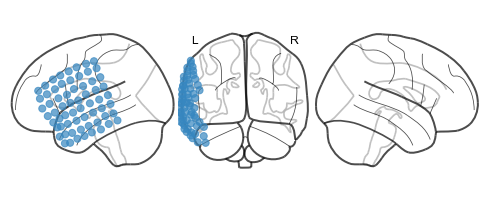

In [27]:
!pip install mne nilearn
clear_output()

import mne
from nilearn.plotting import plot_markers

# Load data into MNE "Raw" object
raw = mne.io.read_raw('encling-data/sub-717_task-monkey_desc-clean_ieeg.fif')
# Plot the electrode coordinates
node_coords = np.vstack([ch['loc'][:3] for ch in raw.info['chs']])
node_values = np.ones(len(node_coords))
plot_markers(node_values, node_coords,
             node_vmin=0, node_vmax=1.5, node_size=50, node_cmap='Blues',
             display_mode='lyr', colorbar=False);

In [30]:
# Reload transcript with embeddings if already generated
import pickle
transcript_f = 'encling-data/monkey_w2v.pkl'
if os.path.exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_w2v = pickle.load(f)
        
transcript_w2v

,word,onset,offset,embedding
0,so,3356.145752,3427.825684,"[-0.037075665, -0.019805377, -0.003584773, 0.0..."
1,there's,3438.065674,3519.985596,"[0.038773842, -0.030825203, 0.033539373, 0.113..."
2,some,3509.745605,3591.665771,"[0.10444655, 0.05336477, -0.00096759317, 0.103..."
3,places,3601.905762,3740.145752,"[-0.006933008, 0.0585454, 0.034995183, 0.04423..."
4,where,3770.865723,3822.065674,"[0.007766569, -0.025417862, 0.0325527, 0.06569..."
...,...,...,...,...
5107,it's,917626.062500,917677.250000,"[0.04729646, -0.03877614, 0.043297127, 0.10919..."
5108,a,917697.750000,917708.000000,NaN
5109,uniquely,917748.937500,917938.375000,"[-0.043124266, -0.084389724, -0.034202002, 0.0..."
5110,human,917969.125000,918097.125000,"[0.022186058, 0.036621526, 0.042821996, 0.1123..."


In [31]:
# Add word onsets as annotations to the raw object
annotations = mne.Annotations(transcript_w2v.onset.to_numpy() / 512,
                              (transcript_w2v.offset - transcript_w2v.onset).to_numpy() / 512,
                              description=transcript_w2v.word.to_numpy())
raw = raw.set_annotations(annotations)
# Extract word onsets from the annotations
events, event_id = mne.events_from_annotations(raw, regexp=None, verbose=False)
word_ids = {word: id for id, word in event_id.items()}
words = [word_ids[word_id] for word_id in events[:, 2]]
print(f'First few words: "{" ".join(words[:20])}"')

First few words: "so there's some places where animals almost never go places that are designed by humans for humans this act ends"


Loading data for 4490 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
4490 matching events found
No baseline correction applied
0 projection items activated


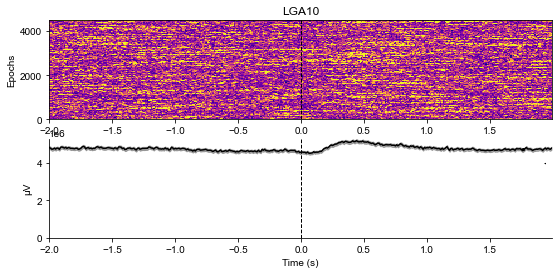

[<Figure size 648x288 with 3 Axes>]

In [32]:
# Compile embeddings from transcript
words_keep = np.where(transcript_w2v['embedding'].notna())[0]
X_w2v = np.vstack(transcript_w2v['embedding'][words_keep])
# Only include events where we have word embeddings
events_ = events[words_keep]
# create epochs without any processing (e.g., baseline correction)
epochs = mne.Epochs(raw, events_, event_repeated='drop',tmin=-2.0, tmax=2.0,picks='ecog',
                    reject_by_annotation=None, detrend=None, baseline=None, verbose=False)
epochs = epochs.load_data()
epochs = epochs.resample(100, verbose=False)

fig, ax = plt.subplots(2, 1, figsize=(9, 4))
epochs.plot_image(picks=[9], colorbar=False, vmin=0, vmax=1e7, cmap='plasma', axes=ax)

In [33]:
# Extract data from epochs object
Y_lags = epochs._data
print(f"ECoG data matrix shape: {Y_lags.shape}")
n_words, n_electrodes, n_lags = Y_lags.shape
Y_lags = Y_lags.reshape(n_words, n_electrodes * n_lags)
print(f"ECoG data matrix shape: {Y_lags.shape}")

ECoG data matrix shape: (4490, 64, 400)
ECoG data matrix shape: (4490, 25600)


In [34]:
!pip install scikit-learn himalaya
clear_output()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score

# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2, shuffle=False)
inner_cv = KFold(n_splits=5, shuffle=False)
# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(StandardScaler(with_mean=True, with_std=True), RidgeCV(alphas=alphas, cv=inner_cv))

In [35]:
# Loop through outer folds and estimate model
Y_predicted = []
for train, test in outer_cv.split(Y_lags):
    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(X_w2v[train],Y_lags[train])
    # Compute predicted response
    predicted = pipeline.predict(X_w2v[test])
    Y_predicted.append(predicted)
# Restack first and second half predictions
Y_predicted = np.vstack(Y_predicted)

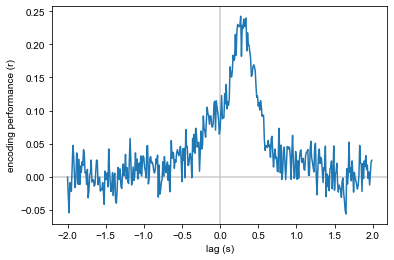

In [36]:
# Evaluate predictions: correlation between predicted and actual time series
scores_lags = correlation_score(Y_lags, Y_predicted)
scores = scores_lags.reshape(n_electrodes, n_lags)
# Plot the correlation for one electrode on all lags
example_electrode = 9
lags = epochs.times
fig, ax = plt.subplots()
ax.axhline(0, color='.8')
ax.axvline(0, color='.8')
ax.plot(lags, scores[example_electrode])
ax.set(xlabel='lag (s)', ylabel='encoding performance (r)');

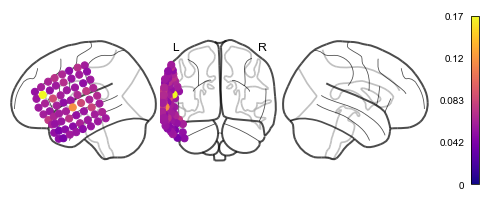

In [37]:
# Plot maximum correlation across lags for all electrodes
node_values = scores.max(-1)
vmax = np.quantile(scores.max(-1), .99)

plot_markers(node_values, node_coords,
             node_size=50, node_cmap='plasma', display_mode='lyr',
             node_vmin=0, node_vmax=vmax, alpha=1)
plt.show()

## 3. 句法特征提取

### 3.1 句法特征抽取

In [38]:
import hanlp
## workshop中的例子，研究中一般会把标点去掉，但是这里保留了标点，模型也是能够解析标点的
Hanlp = hanlp.load(hanlp.pretrained.mtl.CLOSE_TOK_POS_NER_SRL_DEP_SDP_CON_ELECTRA_SMALL_ZH) # 选择使用的模型
doc = Hanlp('欢迎大家参加工作坊！', tasks=['dep', 'con']) # 在tasks中选择需要的任务，如果不设置就进行所有任务（运行起来会慢一点）
doc.pretty_print()

* 成分句法

    成分句法输出得到的是一个树结构的数据，可以看作一个嵌套的列表。我们可以：
    * 访问句法树的一些属性
    * 转换为括号表示法，计算括号数量
    * 访问句法树的子树

In [39]:
Hanlp = hanlp.load(hanlp.pretrained.mtl.CLOSE_TOK_POS_NER_SRL_DEP_SDP_CON_ELECTRA_SMALL_ZH)
doc = Hanlp('欢迎大家参加工作坊！')
tree = doc['con']

In [40]:
# 叶结点的位置
for i in range(len(tree.leaves())):
    print(tree.leaf_treeposition(i))

(0, 0, 0, 0)
(0, 0, 1, 0, 0)
(0, 0, 2, 0, 0, 0)
(0, 0, 2, 0, 1, 0, 0)
(0, 1, 0)


In [41]:
tree[0, 0, 1, 0, 0]

'大家'

In [42]:
# 转为括号表示法
bracket_form = tree.pformat().replace ('\n', '').replace(' ', '') # 去掉换行和空格
bracket_form

'(TOP(IP(VP(VV欢迎)(NP(PN大家))(IP(VP(VV参加)(NP(NN工作坊)))))(PU！)))'

In [43]:
# 转换为Chomsky Normal Form，可以用tree.un_chomsky_normal_form()转换回来
tree.chomsky_normal_form() 
bracket_form = tree.pformat().replace ('\n', '').replace(' ', '')
print(bracket_form)

(TOP(IP(VP(VV欢迎)(VP|<NP-IP>(NP(PN大家))(IP(VP(VV参加)(NP(NN工作坊))))))(PU！)))


In [44]:
# 输出中有些节点只派生出一支，是冗余的（例如最外层的TOP根结点只派生出IP，以及句子中的IP只派生出VP），可以选择压缩节点
tree.collapse_unary(collapseRoot=True, joinChar='|') # 压缩冗余节点，压缩的节点用｜来表示
bracket_form = tree.pformat().replace ('\n', '').replace(' ', '')
bracket_form 

'(TOP|IP(VP(VV欢迎)(VP|<NP-IP>(NP(PN大家))(IP|VP(VV参加)(NP(NN工作坊)))))(PU！))'

In [45]:
import re
import pandas as pd
# 计算括号表示法中每个词的括号数
bracket_clean= re.sub("([^()])", "", bracket_form) # 只保留括号
print(bracket_clean)

# 计算左括号数
left_bracket = [len(re.findall("\(", i)) for i in bracket_clean] 
left_bracket_count = []
for i in left_bracket:
    if len(left_bracket_count) == 0 or (i == 1 and j != 1):
        left_bracket_count.append(1)
    elif i == 1 and j == 1:
        left_bracket_count[-1] += 1
    j = i
print("左括号数:", left_bracket_count)

# 计算右括号数
right_bracket = [len(re.findall("\)", i)) for i in bracket_clean] 
right_bracket_count = []; j = 0
for i in right_bracket:
    if i == 1 and j != 1:
        right_bracket_count.append(1)
    elif i == 1 and j == 1:
        right_bracket_count[-1] += 1
    j = i
print("右括号数:", right_bracket_count)

((()((())(()(()))))())
左括号数: [3, 3, 2, 2, 1]
右括号数: [1, 2, 1, 5, 2]


In [46]:
# 可以保存为 dataframe 进行进一步的句法特征分析
df_bracket = pd.DataFrame([tree.leaves(), left_bracket_count, right_bracket_count]).T
df_bracket.columns = ['word', 'left_bracket', 'right_bracket']
# df_bracket.to_csv('bracket.csv', index=False) # 保存为csv文件
df_bracket

,word,left_bracket,right_bracket
0,欢迎,3,1
1,大家,3,2
2,参加,2,1
3,工作坊,2,5
4,！,1,2


In [47]:
# 句法树的属性
print("Terminal nodes:", tree.leaves())
print("Tree depth:", tree.height())
print("Tree productions:", tree.productions())
print("Part of Speech:", tree.pos())

Terminal nodes: ['欢迎', '大家', '参加', '工作坊', '！']
Tree depth: 7
Tree productions: [TOP|IP -> VP PU, VP -> VV VP|<NP-IP>, VV -> '欢迎', VP|<NP-IP> -> NP IP|VP, NP -> PN, PN -> '大家', IP|VP -> VV NP, VV -> '参加', NP -> NN, NN -> '工作坊', PU -> '！']
Part of Speech: [('欢迎', 'VV'), ('大家', 'PN'), ('参加', 'VV'), ('工作坊', 'NN'), ('！', 'PU')]


In [48]:
# 句法树的嵌套结构
for i in tree.subtrees():  # 根据Tree productions，遍历所有的子树，每一棵子树都是一个Tree对象，可以进行之前相同的操作
    print(i)

(TOP|IP
  (VP
    (VV 欢迎)
    (VP|<NP-IP> (NP (PN 大家)) (IP|VP (VV 参加) (NP (NN 工作坊)))))
  (PU ！))
(VP (VV 欢迎) (VP|<NP-IP> (NP (PN 大家)) (IP|VP (VV 参加) (NP (NN 工作坊)))))
(VV 欢迎)
(VP|<NP-IP> (NP (PN 大家)) (IP|VP (VV 参加) (NP (NN 工作坊))))
(NP (PN 大家))
(PN 大家)
(IP|VP (VV 参加) (NP (NN 工作坊)))
(VV 参加)
(NP (NN 工作坊))
(NN 工作坊)
(PU ！)


In [49]:
# 通过索引访问句法树的子树
treepositions = tree.treepositions() # 所有节点的索引
treepositions

[(),
 (0,),
 (0, 0),
 (0, 0, 0),
 (0, 1),
 (0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 0, 0, 0),
 (0, 1, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 1, 0),
 (0, 1, 1, 1, 0, 0),
 (1,),
 (1, 0)]

In [50]:
for i in treepositions: # 遍历所有节点
    print(tree[i])

(TOP|IP
  (VP
    (VV 欢迎)
    (VP|<NP-IP> (NP (PN 大家)) (IP|VP (VV 参加) (NP (NN 工作坊)))))
  (PU ！))
(VP (VV 欢迎) (VP|<NP-IP> (NP (PN 大家)) (IP|VP (VV 参加) (NP (NN 工作坊)))))
(VV 欢迎)
欢迎
(VP|<NP-IP> (NP (PN 大家)) (IP|VP (VV 参加) (NP (NN 工作坊))))
(NP (PN 大家))
(PN 大家)
大家
(IP|VP (VV 参加) (NP (NN 工作坊)))
(VV 参加)
参加
(NP (NN 工作坊))
(NN 工作坊)
工作坊
(PU ！)
！


* 3.1.2 依存句法
    依存句法的数据结构更加简单，为一个列表`[(head, relation), ... ]`。列表中第$i$个值中包括了它的核心词的位置以及它与核心词之间的依存关系

In [51]:
Hanlp = hanlp.load(hanlp.pretrained.mtl.CLOSE_TOK_POS_NER_SRL_DEP_SDP_CON_ELECTRA_SMALL_ZH)
doc = Hanlp('欢迎大家参加工作坊！')
doc['dep']

[(0, 'root'), (1, 'dobj'), (1, 'dep'), (3, 'dobj'), (1, 'punct')]

In [52]:
# 可以保存为 dataframe 进行进一步的句法特征分析
df_dep = pd.DataFrame(doc['dep'], columns=['head', 'rel'])
df_dep['word'] = doc['tok/fine']
df_dep = df_dep[['word', 'head', 'rel']]
df_dep

,word,head,rel
0,欢迎,0,root
1,大家,1,dobj
2,参加,1,dep
3,工作坊,3,dobj
4,！,1,punct


### 3.2 批量操作

只需要将要处理的句子放在list中，一起进行特征抽取即可。这对所有特征都适用，不仅是句法特征。

In [53]:
sentences = ['2024年工作坊在广州召开。', '欢迎大家参加工作坊！']
docs = Hanlp(sentences)
docs.pretty_print()

In [54]:
# 提取出来的特征直接索引即可
print("句子数量为:", docs.count_sentences())
for i in range(docs.count_sentences()):
    print(docs['tok/fine'][i])

句子数量为: 2
['2024', '年', '工作坊', '在', '广州', '召开', '。']
['欢迎', '大家', '参加', '工作坊', '！']


* 验证温度(temperature)参数对于模型生成的影响

In [55]:
model_name = 'uer/gpt2-chinese-cluecorpussmall'
model = AutoModelForCausalLM.from_pretrained(model_name)# , torch_dtype=torch.float16,)
model = model.eval()
tokenizer = BertTokenizer.from_pretrained(model_name,use_fast=False)
input_ids = tokenizer(['欢迎参加'], return_tensors="pt").input_ids
if torch.cuda.is_available():
  input_ids = input_ids.to('cuda')
  model = model.to('cuda')

# random sample
for t in [0.3, 1.0]:
    print("="*15 + f"随机搜索, 温度={t}" + "="*15)
    for i in range(5):
        generate_input = {
            "input_ids":input_ids, "max_new_tokens":20,
            "do_sample":True, "top_k":50, "top_p":0.95, "temperature":t,
            "eos_token_id":tokenizer.eos_token_id,
            "bos_token_id":tokenizer.bos_token_id,
            "pad_token_id":tokenizer.unk_token_id,
        }
        generate_ids  = model.generate(**generate_input)
        text = tokenizer.decode(generate_ids[0], skip_special_tokens=True)
        print(f"iteration {i}: {text}")
  


===============随机搜索, 温度=0.3===============
iteration 0: 欢 迎 参 加 的 是 一 个 朋 友 的 婚 礼 ， 在 这 里 举 行 的 ， 地 方 不
iteration 1: 欢 迎 参 加 乐 队 的 演 出 ， 很 有 意 思 ， 很 有 意 思 ， 很 有 意 思
iteration 2: 欢 迎 参 加 来 自 全 球 的 各 种 活 动 ， 有 机 会 去 看 看 ， 也 有 机
iteration 3: 欢 迎 参 加 的 一 个 活 动 ， 去 的 时 候 是 下 午 ， 人 不 多 ， 环 境
iteration 4: 欢 迎 参 加 拉 丁 舞 比 赛 ， 是 一 种 什 么 样 的 体 验 ？ 欢 迎 参 加
===============随机搜索, 温度=1.0===============
iteration 0: 欢 迎 参 加 来 了 解 一 下 这 款 游 戏 ， 这 款 游 戏 有 哪 些 地 方 值
iteration 1: 欢 迎 参 加 、 给 力 购 物 、 给 力 商 品 。 于 书 籍 之 中 的 品 质
iteration 2: 欢 迎 参 加 书 展 来 看. 一 直 很 喜 欢 刘 老 师 的 书 很 不 错 的.
iteration 3: 欢 迎 参 加 宝 宝 的 百 科 全 书 百 科 全 书 中 的 全 部 内 容 都 包 括
iteration 4: 欢 迎 参 加 婚 礼 的 ~ ~ 感 觉 环 境 很 好 ！ 里 面 好 多 好 吃 的 ，


In [56]:
# greedy search
print("="*15 + f"贪婪搜索" + "="*15)
for i in range(5):
    generate_input = {
        "input_ids":input_ids, "max_new_tokens":20, "do_sample":False,
        "eos_token_id":tokenizer.eos_token_id,
        "bos_token_id":tokenizer.bos_token_id,
        "pad_token_id":tokenizer.unk_token_id,
    }
    generate_ids  = model.generate(**generate_input)
    text = tokenizer.decode(generate_ids[0], skip_special_tokens=True)
    print(f"iteration {i}: {text}")

===============贪婪搜索===============
iteration 0: 欢 迎 参 加 的 是 一 个 朋 友 的 婚 礼 ， 环 境 很 好 ， 菜 品 也 很 好
iteration 1: 欢 迎 参 加 的 是 一 个 朋 友 的 婚 礼 ， 环 境 很 好 ， 菜 品 也 很 好
iteration 2: 欢 迎 参 加 的 是 一 个 朋 友 的 婚 礼 ， 环 境 很 好 ， 菜 品 也 很 好
iteration 3: 欢 迎 参 加 的 是 一 个 朋 友 的 婚 礼 ， 环 境 很 好 ， 菜 品 也 很 好
iteration 4: 欢 迎 参 加 的 是 一 个 朋 友 的 婚 礼 ， 环 境 很 好 ， 菜 品 也 很 好
